# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# path to training, validation and testing data
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test = test['features'],  test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import pandas as pd

# import classes that will be used for traffic sign classification
df_sign_classes = pd.read_csv('./signnames.csv')

print(df_sign_classes)

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(df_sign_classes['ClassId'].unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

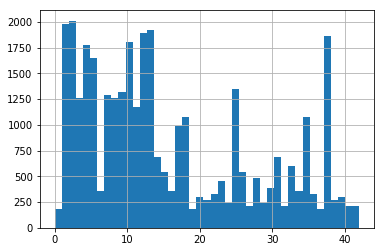

In [4]:
### Data exploration visualization
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# plot the histogram of the training labels, to see their distribution and quantity
sr_y_train = pd.Series(y_train)
sr_y_train.hist(bins=n_classes)

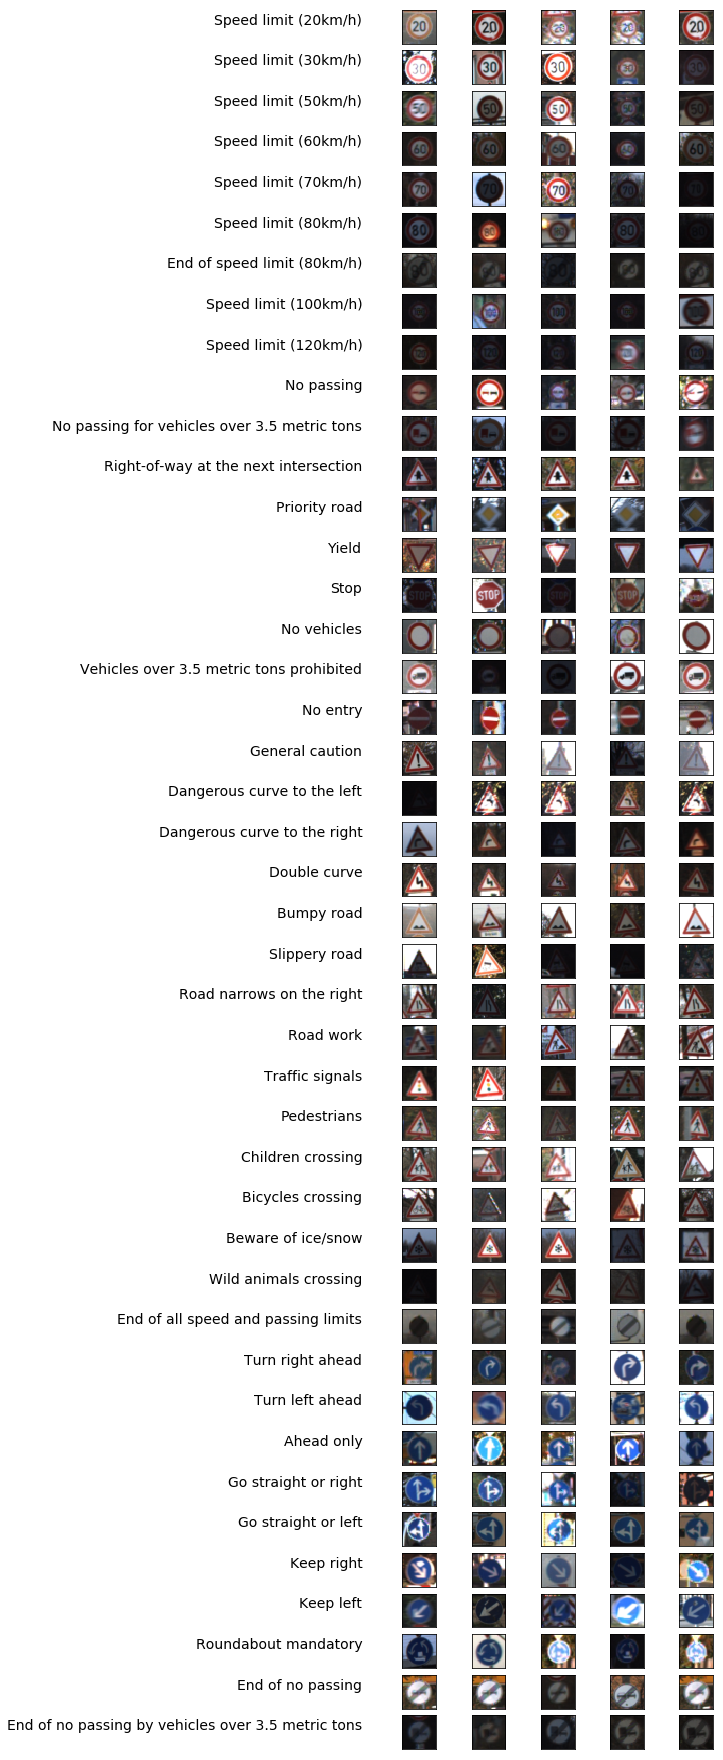

In [5]:
# show examples of training data

import random
import numpy as np

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display

SAMPLES_FOR_ROW = 5

def samples(clazz, _from, amount=1):
    """return 'amount' random indexes to images of a given class"""
    filtered = _from[_from == clazz]
    return np.random.choice(filtered.index, amount if amount >= 0 else 0)

# initialize a progress bar
f = IntProgress(min=0, max=n_classes)
f.border = 1
display(f)

# get the label of the classes as a list
# we will be using as labels in the plot
labels = df_sign_classes['SignName'].tolist()


# create the multiplot
_, axes = plt.subplots(nrows=n_classes, ncols=SAMPLES_FOR_ROW, figsize=(6, 32))
plt.setp(axes.flat, xticks=[], yticks=[])


# for every row (a sign category) assign a random
# image of the corresponding clas
for sign_class in range(n_classes):
    for i,img_idx in zip(range(SAMPLES_FOR_ROW), samples(sign_class, _from=sr_y_train, amount=SAMPLES_FOR_ROW)):
    
        # assign the image
        current_plot = axes[sign_class][i]
        current_plot.imshow(X_train[img_idx])
        
        # if in the first column, set the left label
        if i % SAMPLES_FOR_ROW == 0: 
           current_plot.set_ylabel(labels[sign_class], size=14, rotation=0,  labelpad=40, ha='right')

        f.value += 1
        

plt.show()



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [6]:
# preprocess the images, that will be converted to gray, equilized and normalized (see pipeline function)

import cv2

def pipeline(img):
    """Convert to gray color, perform histogram equalisation and normalize the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = cv2.equalizeHist(gray)
    return cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# apply the image processing to all the sets and store the results in
# a different arrays
X_train_norm = [ pipeline(X_train[n]) for n in range(len(X_train)) ]
X_valid_norm = [ pipeline(X_valid[n]) for n in range(len(X_valid)) ]
X_test_norm =  [ pipeline(X_test[n]) for n in range(len(X_test)) ]


# the gray conversion squashed one dimension, we need to put in place again
# for tensorflow
X_train_norm = np.reshape(X_train_norm, (np.shape(X_train_norm)[0],32,32,1))
X_valid_norm = np.reshape(X_valid_norm, (np.shape(X_valid_norm)[0],32,32,1))
X_test_norm  = np.reshape(X_test_norm, (np.shape(X_test_norm)[0],32,32,1))


### Data augmentation

From the histogram above we can see that the training set is not uniformly distributed. Not only: the most represented sign types are still not enough to train a moderately complex CNN. We need data augmentation. 

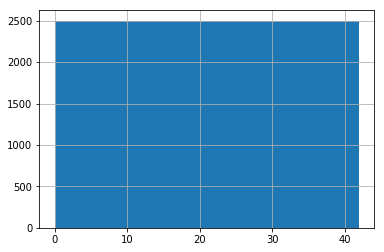

In [15]:

def change_perspective(img, new_bbox):
    """It takes an image and warp to the new bounding box by
       using homography"""
    
    # the bounding box on the source image, we basically
    # select the entire image to be warped
    pts_src = np.float32([[0,0],[img.shape[0],0],[0,img.shape[1]],[img.shape[0],img.shape[1]]])
   
    # four new corresponding corners in the destination image
    pts_dst = np.float32(new_bbox)
 
    # calculate the homography
    h, status = cv2.findHomography(pts_src, pts_dst)
     
    # warp source image to destination based on homography
    return cv2.warpPerspective(img, h, (img.shape[1],img.shape[0]), borderMode=cv2.BORDER_REPLICATE)

def rotate(img, center, angle):
    """Rotate the input image around the center, of a certain amount of degrees"""
    
    # get the rotation (and scale) matrix 
    R = cv2.getRotationMatrix2D(center, angle, 1)
   
    # apply the affine transformation
    return cv2.warpAffine(img, R, (img.shape[0], img.shape[1]), borderMode=cv2.BORDER_REPLICATE)

def apply_random_transform(img):
    """Apply a random transformation to the input image"""
    
    funDict = {
        0 : lambda img: change_perspective(img, [[0,0],[32,3],[0,32],[32,28]]),
        1 : lambda img: change_perspective(img, [[0,3],[32,0],[0,28],[32,32]]),
        2 : lambda img: change_perspective(img, [[4,0],[28,0],[0,32],[32,32]]),
        3 : lambda img: change_perspective(img, [[0,0],[29,3],[3,32],[32,28]]),
        4 : lambda img: change_perspective(img, [[2,2],[32,0],[0,30],[29,32]]),
        5 : lambda img: change_perspective(img, [[2,2],[30,2],[2,32],[32,30]]),
        6 : lambda img: rotate(img, (16, 16), -15 + np.random.uniform(30)),  # [-15, 15] random rotation
        7 : lambda img: rotate(img, (15, 15), -10 + np.random.uniform(20))  # [-10, 10] random rotation
    }
    
    # get a random index
    fun_idx = np.random.choice(len(funDict), 1)[0]
    
    # apply the function at random index fun_idx to the image
    return funDict[fun_idx](img)
    
    
# =========== Data augmentation ==========
# recall that that sr_y_train is a pandas series built from y_train

# desired amount of images per class. The missing images will be
# created by random transformations, like rotations and changes in
# perspective
IMGS_PER_CLASS = 2500   

# initialize a progress bar
f = IntProgress(min=0, max=n_classes)
f.border = 1
display(f)

# create a training set that will be augmented
X_train_augmented = np.copy(X_train_norm)
y_train_augmented = np.copy(y_train)

# cycle on all the classes: the idea is to see how many images 
# for a given class are there, get a sample of images for the 
# same class (in the same amount), transform the images and 
# add them to the training set
for i in range(n_classes):
    
    # calculate how many images to add for the class ith
    missing = IMGS_PER_CLASS - sr_y_train[sr_y_train==i].count()

    # get a sample of indexes for a given class, get the corresponding images and 
    # apply a random transformation, then return as a list
    extra_images = [ apply_random_transform(X_train_norm[idx]) for idx in 
                          samples(i, _from=sr_y_train, amount=missing) ]
    
    # reshape
    extra_images = np.reshape(extra_images, (np.shape(extra_images)[0],32,32,1))

    # append the list of extra images to the normalized training set
    X_train_augmented = np.concatenate((X_train_augmented, extra_images), axis=0)
    
    # append the corresponding class for all the added images to the 
    # array for the ground truth
    y_train_augmented = np.concatenate((y_train_augmented, np.repeat(i, repeats=missing)))
    
    f.value += 1
    
# check the histogram: now all the classes should have 
# the same amount of images
sr_y_train_augmented = pd.Series(y_train_augmented)
sr_y_train_augmented.hist(bins=n_classes)

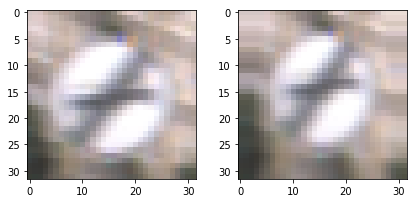

In [14]:
# draw an image and its random transformation, for demo purposes
fig, (a, b) = plt.subplots(1, 2)
fig.tight_layout()
a.imshow(X_train[49])
b.imshow(apply_random_transform(X_train[49]))

### Model Architecture

In [ ]:
# we start from the LeNet CCN of the lab and see how it goes...

from tensorflow.contrib.layers import flatten
import tensorflow as tf


def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

def LeNet(x):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    
    # using the std deviation as sqrt(2.0/n) where n is the fan in
    # as suggested here http://arxiv-web3.library.cornell.edu/abs/1502.01852
    sigma_1 = np.sqrt(2.0/(5*5*12))
    sigma_2 = np.sqrt(2.0/(5*5*32))
    sigma_3 = np.sqrt(2.0/(800))
    sigma_4 = np.sqrt(2.0/(200))
    sigma_5 = np.sqrt(2.0/(84))

    # ====== Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    with tf.name_scope('conv_1'):
       
       conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma_1))
       conv1_b = tf.Variable(tf.zeros(12))
       conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

       # Activation.
       conv1 = tf.nn.relu(conv1)
       
       # log weight and bias of the this convolution
       variable_summaries(conv1_W)
       variable_summaries(conv1_b)


    # ====== Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # ====== Layer 2: Convolutional. Output = 10x10x32.
    with tf.name_scope('conv_2'):
       
       conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 32), mean = mu, stddev = sigma_2))
       conv2_b = tf.Variable(tf.zeros(32))
       conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
       # Activation.
       conv2 = tf.nn.relu(conv2)
    
       # log weight and bias of the second convolution
       variable_summaries(conv2_W)
       variable_summaries(conv2_b)
       
    
    # ====== Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # ====== Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # ====== Dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # ====== Layer 3: Fully Connected. Input = 800. Output = 200.
    with tf.name_scope('fc_1'):
        
        fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma_3))
        fc1_b = tf.Variable(tf.zeros(200))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
        # Activation.
        fc1    = tf.nn.relu(fc1)
        
        # log weight and bias of the first connected layer
        variable_summaries(fc1_W)
        variable_summaries(fc1_b)
        
    # ====== Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # ====== Layer 4: Fully Connected. Input = 200. Output = 84.
    with tf.name_scope('fc_2'):
        
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma_4))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
        # Activation.
        fc2    = tf.nn.relu(fc2)
        
        # log weight and bias of the second connected layer
        variable_summaries(fc2_W)
        variable_summaries(fc2_b)
    
    # ====== Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # ====== Layer 5: Fully Connected. Input = 84. Output = 43.
    with tf.name_scope('fc_2'):
        
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma_5))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        # log weight and bias of the last layer
        variable_summaries(fc3_W)
        variable_summaries(fc3_b)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [ ]:
from sklearn.utils import shuffle

rate = 0.001
EPOCHS = 40
BATCH_SIZE = 512


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# starting from scratch
tf.reset_default_graph()

# define some placeholders (inputs to the graph)
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder("float")

# =====! define the graph
logits = LeNet(x)

# transform the classes to one hot encoding (to be compared with output of the net)
one_hot_y = tf.one_hot(y, 43)

# node to calculate the cross_entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)

# node to sum over all the cross_entropies for the batch
loss_operation = tf.reduce_mean(cross_entropy)

# node to dump the accuracy/loss into the logs
tf.summary.scalar('accuracy', loss_operation)

# node to optimize
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

# entry point to train the net
training_operation = optimizer.minimize(loss_operation)                                                    

# node for the prediction 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# merge all the reports
merged = tf.summary.merge_all()
                                                        
# here the training loop
with tf.Session() as sess:
    
    train_writer = tf.summary.FileWriter('/tmp/train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    num_examples = len(X_train_augmented)
    
    print("Training...\n")
    
    for i in range(EPOCHS):
        
        X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_augmented[offset:end], y_train_augmented[offset:end]
            summary, _ = sess.run( [merged, training_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_writer.add_summary(summary, offset)

        validation_accuracy = evaluate(X_valid_norm, y_valid)
        train_accuracy = evaluate(X_train_augmented, y_train_augmented)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver = tf.train.Saver()
    saver.save(sess, './lenet')
    print("Model saved")

In [ ]:
# test the model 

with tf.Session() as sess:
    
    # load the model structure
    new_saver = tf.train.import_meta_graph('lenet.meta')

    # restore variables from disk.
    new_saver.restore(sess, './lenet')

    print("Model restored.")

    test_accuracy = evaluate(X_test_norm, y_test)
    
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

I took 5 screenshots from Berlin street views using google maps. Saved in the test-images dir of this project 

### Load and Output the Images

In [ ]:
import os

file_list = os.listdir("test-images/")

print(sorted(file_list))

# load images and processing them by using the same pipeline
image_list = [pipeline(cv2.imread('test-images/' + img)) for img in sorted(file_list)]

# right shape of image list
X_mine = np.reshape(image_list, (5,32,32,1))

# ground truth for my images
y_mine = np.array([11, 29, 2, 37, 5])

# print the images
for image in image_list:
    plt.imshow(image, cmap='gray')
    plt.show()
    
    

### Predict the Sign Type for Each Image

In [ ]:
with tf.Session() as sess:
    
    # load the model structure
    new_saver = tf.train.import_meta_graph('lenet.meta')

    # restore variables from disk.
    new_saver.restore(sess, './lenet')

    print("Model restored.")

    predictions = sess.run(tf.argmax(logits, 1), feed_dict={x: X_mine, keep_prob: 1.0})
    
    print("Predicted classes: ", predictions)    
    print("Actual classes: ", y_mine)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    
    # load the model structure
    new_saver = tf.train.import_meta_graph('lenet.meta')

    # restore variables from disk.
    new_saver.restore(sess, './lenet')

    print("Model restored.")

    accuracy = evaluate(X_mine, y_mine)
    
    print("Accuracy = {:.3f}".format(accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    
    # load the model structure
    new_saver = tf.train.import_meta_graph('lenet.meta')

    # restore variables from disk.
    new_saver.restore(sess, './lenet')

    print("Model restored.")

    predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: X_mine, keep_prob: 1.0})
    
    print("Predicted classes: \n", predictions.indices)    
    print("Actual classes: ", y_mine)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(tf_session, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=tf_session, feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
with tf.Session() as sess:
    
    # load the model structure
    new_saver = tf.train.import_meta_graph('lenet.meta')

    # restore variables from disk.
    new_saver.restore(sess, './lenet')

    print("Model restored.")
    
    # get the first activation node (first relu in my lenet)
    first_activation = sess.graph.get_tensor_by_name('conv_1/Relu:0')
    
    # evaluate the node and print all the layers
    outputFeatureMap(sess, X_mine, first_activation, activation_min=-1, activation_max=-1, plt_num=1)
    
    plt.show()

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 